In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import networkx as nx
import os, sys
from itertools import product
from matplotlib.animation import FuncAnimation
import math
#plt.style.use('seaborn-pastel')
#from tqdm.autonotebook import tqdm

In [31]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,8)})

alpha = 1
b = 30
agents = [] #global array to store all agents

#global function that calculates the weight of the edge, args: the 2 nodes (agent class objects)
def Edge_Weight(node1,node2):
        return 1/(1+math.exp(alpha*((node1.m-node2.m)-b)))
                

In [32]:
class MoneyAgent(Agent):
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.m = self.model.T
        self.lamda = round(random.uniform(0.1,1),1)
        while (self.lamda == 1):
            self.lamda = round(random.uniform(0.1,1),1)
        agents.append(self)
        
    def neighbors(self):
        neighbors_nodes = list(nx.all_neighbors(self.model.G,self.unique_id))
        neighbors = []
        for node in neighbors_nodes:
            for agent in agents:
                if(agent.unique_id == node):
                    neighbors.append(agent)
        return neighbors
            
    def give_money(self):
        neighbors = self.neighbors()
        epsilon = random.random()
        if len(neighbors) > 1 :
            other = self.random.choice(neighbors)
            while(other.unique_id == self.unique_id):
                other = self.random.choice(neighbors)  
            w = self.model.G[self.unique_id][other.unique_id]['weight'] 
            #print(w)
            if(w >= random.random()): 
                xi = self.m
                xj = other.m
                delta_m = (1-self.lamda)*(xi - epsilon*(xi + xj))
                xi_new = xi - delta_m
                xj_new = xj + delta_m
                other.m = xj_new
                self.m = xi_new
                self.model.trade+=1
                for neighbor in neighbors:
                    self.model.G[self.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(self,neighbor)
                other_neighbors = other.neighbors()
                for neighbor in other_neighbors:
                    if(neighbor.unique_id != other.unique_id):
                        #print("Other: {}  Neighbor: {}".format(other.unique_id,neighbor.unique_id))
                        self.model.G[other.unique_id][neighbor.unique_id]['weight'] = Edge_Weight(other,neighbor)
                
    def Local_Attachment(self):
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.model.nodes)
            node1 = random.choice(self.model.nodes)
        for agent in agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.model.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a))
        
    
    def Link_Deletion(self):
        node1 = random.choice(self.model.nodes)
        node2 = random.choice(self.model.nodes)
        while(self.model.G.has_edge(node1,node2)==False):
            node1 = random.choice(self.model.nodes)
            node2 = random.choice(self.model.nodes)
        self.model.G.remove_edge(node1,node2)
        
                 
    def step(self):
        if self.m > 0:
            self.give_money()
        self.Local_Attachment()
        self.Link_Deletion()

In [33]:
class BoltzmannWealthModelNetwork(Model):
    """A model with some number of agents."""

    def __init__(self,T,N): #N- number of agents

        self.N = N
        self.T = T
        self.trade = 0
        self.count = 0
        self.G = nx.barabasi_albert_graph(n=N, m = 1)
        nx.set_edge_attributes(self.G, 1, 'weight') #setting all initial edges with a weight of 1
        #print(nx.get_edge_attributes(self.G,'weight'))
        #nx.draw(self.G)
        self.nodes = np.linspace(0,N-1,N, dtype = 'int') #to keep track of the N nodes   
        self.layout = nx.spring_layout(self.G)
        
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {'trade': 'trade'},agent_reporters={"mi":'m','lamda':'lamda' })
        
        for i, node in enumerate(self.G.nodes()):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
           
        self.running = True
        self.datacollector.collect(self)
        
    def Global_Attachment(self):
        #print("Global Attachment no: {}".format(self.count))
        node1 = random.choice(self.nodes)
        node2 = random.choice(self.nodes)
        while(self.G.has_edge(node1,node2)==True):
            node2 = random.choice(self.nodes)
            node1 = random.choice(self.nodes)
        #adding the edge node1-node2
        for agent in agents:
            if(agent.unique_id == node1):
                node1_a = agent
            if(agent.unique_id == node2):
                node2_a = agent
        self.G.add_edge(node1,node2,weight = Edge_Weight(node1_a,node2_a))
            

    def step(self):
        self.schedule.step()
        # collect data
        self.datacollector.collect(self)

    def run_model(self, n):
        for i in tqdm(range(n)):
            self.step()
            self.trade = 0
            self.Global_Attachment()
            if(i==n-1):
                nx.draw(self.G)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


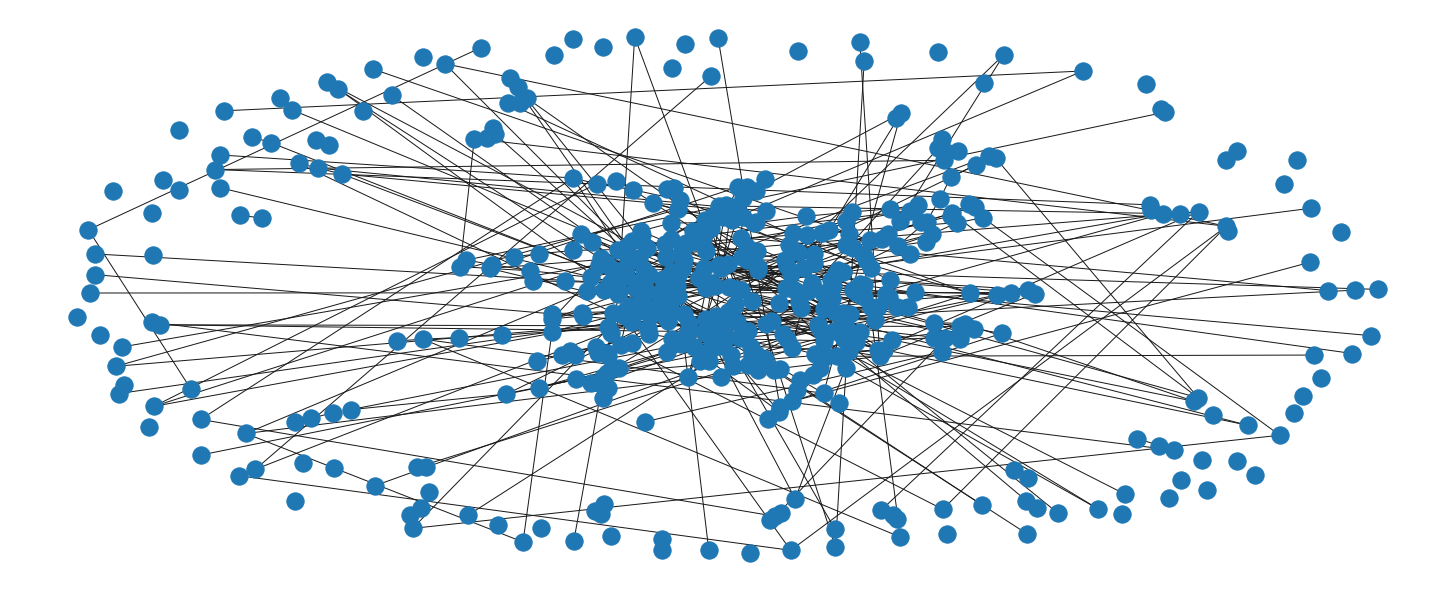

In [34]:
N = 500
T = 100
steps = 100
model = BoltzmannWealthModelNetwork(T,N)
model.run_model(steps)
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df.reset_index(level=1, inplace = True)
agent_df['mt'] = agent_df.mi/T

In [35]:
file = "AlbertBarabasi\Steps{}b_is_30_w_is_RANDOM_alpha_1_m_2".format(steps)
os.makedirs(file)

In [36]:
#saving files
model_df.loc[1:].to_csv(file + "\Model.csv")               
agent_df['mt'] = agent_df.mi/T
agent_df.to_csv(file +"\Agent.csv")

In [37]:
data = pd.read_csv(file + "\Agent.csv")
data.head()

,Step,AgentID,mi,lamda,mt
0,0,0,100.0,0.8,1.0
1,0,1,100.0,0.3,1.0
2,0,2,100.0,0.4,1.0
3,0,3,100.0,0.5,1.0
4,0,4,100.0,0.5,1.0


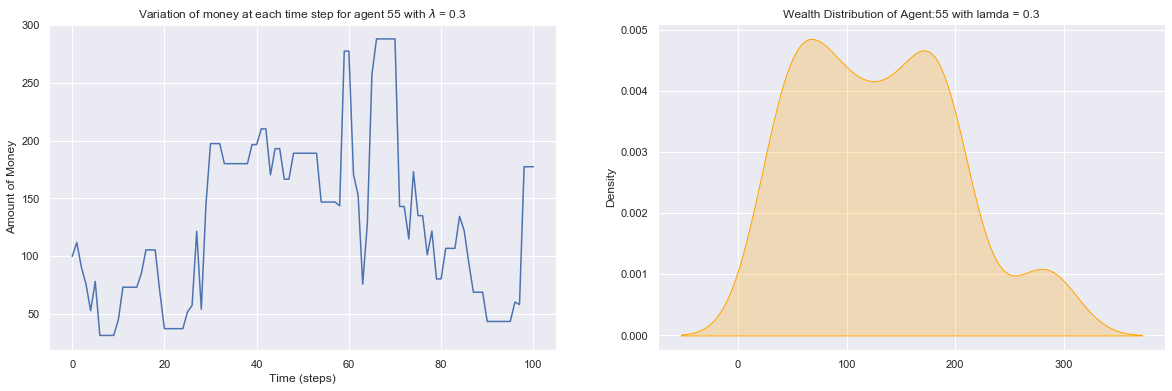

In [44]:
agent = random.randint(0,499)
time = (data.loc[data['AgentID']==agent, 'Step'].reset_index(drop = True)).to_numpy()
money = (data.loc[data['AgentID']==agent, 'mi'].reset_index(drop = True)).to_numpy()
lamda = data.loc[data['AgentID'] == agent, 'lamda'].reset_index(drop = True)[0]
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(20,6)})
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
ax1.plot(time,money)
ax1.set_title("Variation of money at each time step for agent {} with $\lambda$ = {}".format(agent,lamda))
ax1.set_xlabel("Time (steps)")
ax1.set_ylabel("Amount of Money")
sns.kdeplot(money, fill =True, color = 'orange', ax = ax2)
ax2.set_title("Wealth Distribution of Agent:{} with lamda = {}".format(agent, lamda))
plt.savefig(file + "\WealthDist_agent{}".format(agent))

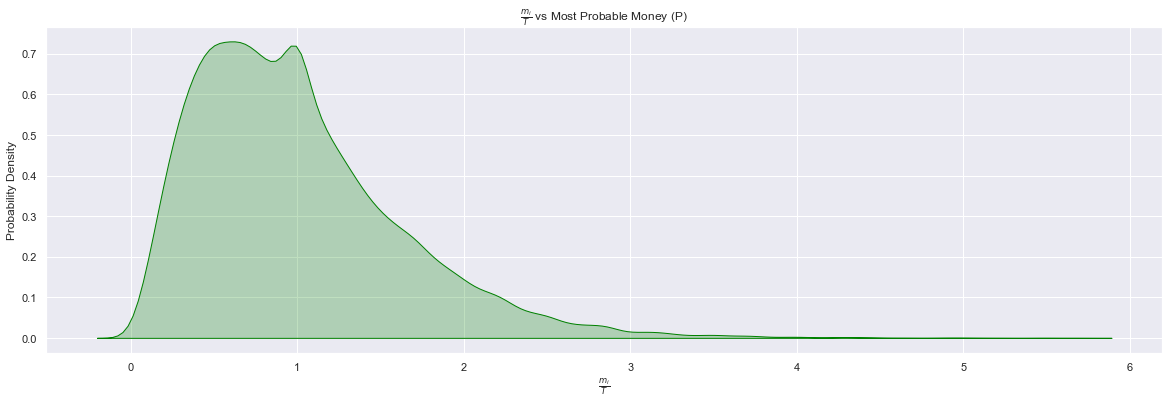

In [45]:
sns.kdeplot(data.mt, fill = True, color = 'green')
plt.xlabel("$\\frac{m_i}{T}$")
plt.ylabel("Probability Density")
plt.title("$\\frac{m_i}{T}$ vs Most Probable Money (P)") 
plt.savefig(file + "\kdeplot_homophily");